In [ ]:
# Mecab 사용
# morphs()로 형태소 분석 후 품사 찾고 필요한 품사를 가진 단어만 골라 추출하는 방식이 아닌..
# nouns()로 그냥 다 명사화하고 빈도수 상위 50개 단어 중 불필요하다 판단되는 단어들을 제거한 후 WordCloud로 시각화했습니다.
# 불필요한 단어들을 제거하고 나니 이전보다는 시각화 자료의 품질이 조금 더 나아졌다고 판단됩니다...만

# 개선점 1. morphs()로 품사가 태깅된 형태소로 나눈 다음, 필요한 품사만 골라 WordCloud로 추출해보기
# 개선점 2. 한식 중에서도 특정 카테고리로만 분석해본다면?? 예를 들어 '한정식' 카테고리의 리뷰만 분석 혹은, '갈비' 카테고리의 리뷰.. 등등
# 개선점 3. WordCloud로 뽑아낸 키워드들 중 메뉴도 뺀다면? 예를 들어 상위 빈도수 단어 중 '고기', '떡볶이'... 처럼 메뉴 키워드가 많은데 메뉴 키워드들도 제거해본다면 ??

In [ ]:
# 이것저것 import
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud.wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# mecab 설치 코드
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd 'Mecab-ko-for-Google-Colab'
!bash install_mecab-ko_on_colab_light_220429.sh


# Okt, Mecab 객체 생성
from konlpy.tag import Okt, Mecab
okt = Okt()
mecab = Mecab()


# 한글 폰트 설치 코드
!apt-get updata -qq
!apt-get install fonts-nanum* -qq

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 9.65 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.4 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-06-09 01:16:48--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::

In [ ]:
# 구글 서버와 드라이브 연결 및 작업 디렉토리 변경
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/세미프로젝트'

Mounted at /content/drive
/content/drive/MyDrive/KDT/세미프로젝트


In [ ]:
# df 생성
df = pd.read_csv('kr3_raw.tsv', sep = '\t')
df

,Region,Rating,Category,Review
0,인덕원,1,삼겹살 고기집,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,인덕원,1,삼겹살 고기집,고기가 정말 맛있었어요! 육즙이 가득있어서 너무 좋았아요\n일하시는분들 너무 친절하...
2,인덕원,1,순대국 찹쌀순대,"잡내없고 깔끔, 담백한 맛의 순대국이 순대국을 안 좋아하는 사람들에게도 술술 넘어갈..."
3,인덕원,1,순대국 찹쌀순대,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다~~ 맛도 좋습니다\n다만 양념...
4,인덕원,1,순대국 찹쌀순대,순대국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요.\n\n그러나 ...
...,...,...,...,...
642408,평택,2,일식/중식/세계음식,"요즘, 핫하게,,,떠오르구 있는 중국집. ㅋ, 맥주의 여파루 속이 안좋지만 와봄. ..."
642409,평택,0,한식,원래 글 안쓰는데 이거는 정말 다른분들 위해서 써야할것같네요 방금 포장주문 해서 왔...
642410,평택,1,한식,"우리팀 단골집, 술먹고 다음 날 가면 푸짐하게 배불리 해장 할 수 있는곳, 주말도 ..."
642411,평택,2,카페/디저트,"원래는 평택에 있었는데, 연남동에도 최근에 생겨서 방문 했는데..진짜 줄이 어마어마..."


In [ ]:
# 누락 데이터 있나요?
df.isnull().sum()

Region       0
Rating       0
Category    24
Review       0
dtype: int64

In [ ]:
# 누락 데이터 없애기
data = df.dropna()
data.isnull().sum()

Region      0
Rating      0
Category    0
Review      0
dtype: int64

In [ ]:
# 긍정적 리뷰와 부정적 리뷰로 나누자
positive = data.loc[(data['Rating'] == 1) & (data['Category'].isin(['한식', '기타 한식', '삼겹살','고기/구이류', '고기 요리', '탕/찌개/전골','한정식/백반/전통 한식','갈비','한정식', '','냉면'])), ['Review']].reset_index(drop=True)
negative = data.loc[(data['Rating'] == 0) & (data['Category'].isin(['한식', '기타 한식', '삼겹살','고기/구이류', '고기 요리', '탕/찌개/전골','한정식/백반/전통 한식','갈비','한정식', '','냉면'])), ['Review']].reset_index(drop=True)

In [ ]:
positive

,Review
0,개인적으로 제일 좋아하는 냉면집\n진짜 집 근처였으면 일주일에 한번씩갈것같아요
1,방화동 구석의 정말 허름한 노포. 아저씨의 응대가 유쾌하고 살갑다. 손으로 쓴 메뉴...
2,아주머니 혼자하시는 식당이고 푸짐해요\n국물이 사골이라 맛있어요 순대는 쏘쏘해요
3,장어가 담백하면서 고소하고 맛있습니다. 비린맛이 적어 물리지 않고 맛있게 먹을 수 ...
4,"오픈 이벤트로 막국수 할인 중이며, 맛있고 푸짐하여 가족 외식으로 괜찮은 곳"
...,...
50137,가격대비 괜찮긴한데 가격을 자꾸 올리고 샐러드바 메뉴는 줄어드는 경향이 있어서 살짝...
50138,리뷰에직원이 친절하지않다더니 정말이네요 선불이라 만원짜리내고 기다리고있는데 거지동냥...
50139,송탄 미군부대 근처에 위치한 곳 원래 로컬맛집으로 되게 유명했는데 삼대천왕에 나온 ...
50140,집에서 40키로 정도 떨어져 있는 곳인데도 몇달에 한번은 이거 먹으러 일부러 갑니다...


In [ ]:
def preprocess(data):
  my_split = []
  for pas in data.iloc:
    data = (pas['Review'])
    # split_data = re.sub('[#"+*!.,~]', '', data).split(' ')
    split_data = re.sub('[^가-힣]', ' ', data).split(' ')
    for i in split_data:
      if len(i) >= 2:
        my_split.append(i)
  return my_split

In [ ]:
my_positive = preprocess(positive)
my_negative = preprocess(negative)
print(len(my_positive))
print(len(my_negative))

1167226
259109


In [ ]:
good_review = str(' '.join(my_positive))
print(good_review[:1000])
print('='*100)

bad_review = str(' '.join(my_negative))
print(bad_review[:1000])

개인적으로 제일 좋아하는 냉면집 진짜 근처였으면 일주일에 한번씩갈것같아요 방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 메뉴판 본게 대체 언제적인지 맛있게 한끼 먹을 있는 좋은 아주머니 혼자하시는 식당이고 푸짐해요 국물이 사골이라 맛있어요 순대는 쏘쏘해요 장어가 담백하면서 고소하고 맛있습니다 비린맛이 적어 물리지 않고 맛있게 먹을 있어요 오픈 이벤트로 막국수 할인 중이며 맛있고 푸짐하여 가족 외식으로 괜찮은 삼겹살 고기랑 지방의 비율 고기질좋고 고추마늘팍팍주시니 김치가 신스틸러 맛있어요 점심에 가면 사람 많아서 조금 기다려야 있어요 도화동 주민센터 앞에 있는 냉면집 냉면 이란 간판을 걸고 장사를 하는 집은 맛이 궁금해 적어도 한번은 방문해서 먹어보는 경향이 있는데 이날 점심꺼리를 고민하던 집이 생각나 방문을 했다 점심 시간에 가게가 붐비는걸 기억이 있어 후다닥 가게로 갔는데 시가 안된 시간이라 그런지 한두 테이블에서 식사를 하고 계셨고 겨울이라서 그런가 냉면보단 칼국수들을 드시고 계셨다 선결제 카드는 카운터에서 해야함 온육수를 따라 마셨는데 보통은 메밀 면수거나 육향이 진한 불투명한 육수가 아닐까 생각했는데 이곳은 뽀얗게 우유빛깔에 완잔 녹진함이 아닌 조금 가벼운 뼈국물 이었다 이걸로 냉면육수가 나오나 궁금해 지더라 냉면은 대자를 시켰고 납짝 군만두도 주문했는데 군만두는 크기가 크고 두꺼워 하나시키면 두개 나오는걸 일행과 하나씩 나눠먹어도 되겠다 생각이 들었다 냉면에 만두 한접시 버거운 느낌이 없지 않았다 냉면은 사이즈로 소중대가 나뉘고 있었고 드디어 나온 냉면은 대자리 답게 푸짐해서 첫인상이 좋았다 냉면 면은 마트에서 파는 느낌이었는데 좀더 질깃했던걸로 기억한다 양념장을 풀기 맛본 냉면 국물은 고기 육수에 동치미를 섞은 맛이 확연히 느껴졌다 둘의 맛이 완전하게 뒤섞인것이 아닌 본인들의 느낌을 완전히 잃지 않은 맛이라고 해야할까 일반 분식집이나 고깃집 냉면보다 조미료 맛이 느껴졌다 양념장을 풀고 맛보니 생각보다 칼칼함이 강했다 하지만 

In [ ]:
good_review[:1000]

print(len(good_review))


5075369


In [ ]:
nouns_goodreview_mecab = mecab.nouns(good_review)
print(nouns_goodreview_mecab[:100])
print('='*100)
nouns_badreview_mecab = mecab.nouns(bad_review)
print(nouns_badreview_mecab[:100])

['개인', '냉면', '집', '근처', '일', '주일', '번', '것', '방화동', '구석', '노포', '아저씨', '응대', '손', '메뉴판', '게', '언제', '끼', '아주머니', '혼자', '식당', '국물', '사골', '순대', '쏘', '쏘', '해요', '장어', '맛', '오픈', '벤트', '막국수', '할인', '중', '가족', '외식', '삼겹살', '고기', '지방', '비율', '고기', '고추', '마늘', '김치', '신스', '틸러', '점심', '사람', '도화동', '주민', '센터', '앞', '냉면', '집', '냉면', '간판', '장사', '집', '맛', '번', '방문', '경향', '이날', '점심', '꺼리', '고민', '집', '방문', '점심', '시간', '가게', '걸', '기억', '가게', '시', '시간', '테이블', '식사', '겨울', '냉면', '칼국수', '선결', '카드', '카운터', '육수', '보통', '메밀', '면수', '육향', '투명', '육수', '생각', '이곳', '우유', '빛깔', '뼈', '국물', '이걸로', '냉면', '육수']
['기억', '오랜만', '반찬', '불고기', '보통', '수준', '전락', '가격', '접객', '마인드', '불만', '번', '걸로', '만족', '집', '걸로', '인터넷', '후기', '서울', '목포', '시간', '운전', '집', '집', '목포', '명인', '맛집', '선정', '인동초', '게', '곳', '사장', '할머니', '손', '계산대', '의자', '이건', '생각', '분', '원', '정식', '개인', '보리밥', '비빔밥', '게', '된장찌개', '돼지고기', '특색', '평양냉면', '고유', '식감', '함흥냉면', '냉면', '육수', '수', '평양냉면', '퓨전', '냉면', '주차', '가능', '표기', '냉면', '집', '발렛', '비', '재료', '중',

In [ ]:
print(nouns_goodreview_mecab[:100])
print(type(nouns_goodreview_mecab))

['개인', '냉면', '집', '근처', '일', '주일', '번', '것', '방화동', '구석', '노포', '아저씨', '응대', '손', '메뉴판', '게', '언제', '끼', '아주머니', '혼자', '식당', '국물', '사골', '순대', '쏘', '쏘', '해요', '장어', '맛', '오픈', '벤트', '막국수', '할인', '중', '가족', '외식', '삼겹살', '고기', '지방', '비율', '고기', '고추', '마늘', '김치', '신스', '틸러', '점심', '사람', '도화동', '주민', '센터', '앞', '냉면', '집', '냉면', '간판', '장사', '집', '맛', '번', '방문', '경향', '이날', '점심', '꺼리', '고민', '집', '방문', '점심', '시간', '가게', '걸', '기억', '가게', '시', '시간', '테이블', '식사', '겨울', '냉면', '칼국수', '선결', '카드', '카운터', '육수', '보통', '메밀', '면수', '육향', '투명', '육수', '생각', '이곳', '우유', '빛깔', '뼈', '국물', '이걸로', '냉면', '육수']
<class 'list'>


In [ ]:
# good_counts = Counter(nouns_goodreview_mecab)
# bad_counts = Counter(nouns_badreview_mecab)

# print(good_counts.most_common(50))
# print('='*100)
# print(bad_counts.most_common(50))


# 불필요한 단어 제거하기 전 결과.

[('맛', 19755), ('고기', 14649), ('집', 9983), ('곳', 6395), ('맛집', 6164), ('것', 5951), ('가격', 5920), ('여기', 5543), ('방문', 5150), ('친절', 4807), ('거', 4722), ('갈비', 4434), ('분', 4432), ('밥', 4362), ('음식', 4354), ('양', 4354), ('때', 4335), ('떡볶이', 4333), ('정도', 4306), ('추천', 4221), ('생각', 3974), ('메뉴', 3927), ('반찬', 3734), ('양념', 3727), ('주문', 3702), ('최고', 3680), ('사람', 3662), ('게', 3528), ('족발', 3402), ('수', 3274), ('김밥', 3257), ('국물', 3190), ('번', 3099), ('식당', 3095), ('하나', 3073), ('듯', 3066), ('곱창', 3043), ('원', 3036), ('데', 2949), ('시간', 2915), ('느낌', 2913), ('냉면', 2857), ('서비스', 2778), ('삼겹살', 2752), ('나', 2619), ('돈', 2605), ('식사', 2598), ('직원', 2565), ('사장', 2562), ('웨이팅', 2557)]
[('맛', 5224), ('고기', 2512), ('집', 1968), ('거', 1949), ('가격', 1824), ('음식', 1774), ('것', 1524), ('분', 1494), ('사람', 1389), ('원', 1309), ('직원', 1270), ('서비스', 1263), ('불친절', 1206), ('주문', 1169), ('곳', 1102), ('정도', 1078), ('게', 1069), ('듯', 1060), ('반찬', 1034), ('번', 991), ('밥', 984), ('생각', 975), ('말', 972), (

In [ ]:
# 상위 50개 단어 중 불필요한거 빼보자.
# 노가다 노가다 노가다 ...
# 더 편하고 효율적인 방법이 있을지?

# good_remove = {'집', '곳', '것', '거', '분',' 양' ,'때', '게', '수', '번', '듯', '원', '데', '나', '돈', '여기', '정도', '하나', '만', '점',
#                '편', '중', '말', '천', '배', '떡', '시', '물', '손', '입', '건', '전', '삼', '저', '겹', '살', '명', '내', '일', '둘', '개',
#                '줄', '안', '간', '앞', '날', '제'}
# bad_remove = {'집', '거', '것', '분', '원', '곳', '게', '정도', '듯', '번', '밥', '말', '데', '손', '때', '여기', '돈', '만', '하나', '나',
#               '개', '수', '건', '전', '천', '건지', '내', '일', '처음', '이상', '점', '명', '저', '물', '줄', '중', '앞', '간', '뭐', '시',
#               '이', '걸', '제', '편', '년', '면', '배', '성비', '바', '옆', '완전', '근처', '상태', '입', '냉', '날', '식'}

good_remove = {'집', '곳', '것', '거', '분',' 양' ,'때', '게', '수', '번', '듯', '원', '데', '나', '돈', '여기', '정도', '하나', '만', '점',
               '편', '중', '말', '천', '배', '떡', '시', '물', '손', '입', '건', '전', '삼', '저', '겹', '살', '명', '내', '일', '둘', '개',
               '줄', '안', '간', '앞', '날', '제', '갈비', '떡볶이', '족발', '김밥', '비빔밥', '제주', '고기', '냉면', '김치', '돼지', '국물',
               '등심', '보쌈', '밥', '양념', '맛집', '오', '존', '곱창', '술', '까스', '막창', '구이', '치즈', '속', '면', '이', '걸', '삼겹살',
               '육회', '한우', '목살', '인분', '볶음밥', '성비', '평', '년', '강', '소고기', '만두', '된장찌개', '강추', '육수', '때문', '다음',
               '등', '굿', '맛', '찜', '육즙', '가격'}
bad_remove = {'집', '거', '것', '분', '원', '곳', '게', '정도', '듯', '번', '밥', '말', '데', '손', '때', '여기', '돈', '만', '하나', '나',
              '개', '수', '건', '전', '천', '건지', '내', '일', '처음', '이상', '점', '명', '저', '물', '줄', '중', '앞', '간', '뭐', '시',
              '이', '걸', '제', '편', '년', '면', '배', '성비', '바', '옆', '완전', '근처', '상태', '입', '냉', '날', '식', '고기', '냉면',
              '떡볶이', '볶음밥', '국물', '갈비', '정식', '육수', '게장', '까스', '저희', '떡갈비', '비빔밥', '소스', '떡', '평', '인분',
              '때문', '김밥', '곱창', '비추', '추천', '추가', '만두', '돼지', '삼겹살', '대비', '맛', '가격'}

nouns_goodreview_mecab = [i for i in nouns_goodreview_mecab if i not in good_remove]
nouns_badreview_mecab = [i for i in nouns_badreview_mecab if i not in bad_remove]

good_counts = Counter(nouns_goodreview_mecab)
bad_counts = Counter(nouns_badreview_mecab)

print(good_counts.most_common(50))
print('='*100)
print(bad_counts.most_common(50))

# 불필요한 단어 제거 후 결과.

[('방문', 5150), ('친절', 4807), ('음식', 4354), ('양', 4354), ('추천', 4221), ('생각', 3974), ('메뉴', 3927), ('반찬', 3734), ('주문', 3702), ('최고', 3680), ('사람', 3662), ('식당', 3095), ('시간', 2915), ('느낌', 2913), ('서비스', 2778), ('식사', 2598), ('직원', 2565), ('사장', 2562), ('웨이팅', 2557), ('만족', 2531), ('분위기', 2495), ('소스', 2269), ('튀김', 2053), ('친구', 2024), ('가게', 1877), ('추가', 1845), ('기본', 1734), ('밑반찬', 1702), ('가족', 1564), ('처음', 1538), ('근처', 1517), ('점심', 1502), ('식감', 1498), ('개인', 1452), ('기대', 1414), ('테이블', 1386), ('기분', 1333), ('자리', 1332), ('예약', 1251), ('포장', 1221), ('저녁', 1160), ('이상', 1157), ('정식', 1136), ('가능', 1135), ('서울', 1113), ('세트', 1103), ('돼지고기', 1079), ('사진', 1076), ('우럭', 1069), ('리뷰', 1055)]
[('음식', 1774), ('사람', 1389), ('직원', 1270), ('서비스', 1263), ('불친절', 1206), ('주문', 1169), ('반찬', 1034), ('생각', 975), ('식당', 940), ('맛집', 878), ('최악', 873), ('기분', 855), ('양', 829), ('시간', 797), ('테이블', 768), ('방문', 759), ('친절', 755), ('사장', 752), ('기대', 605), ('실망', 591), ('메뉴', 573), ('손님', 552

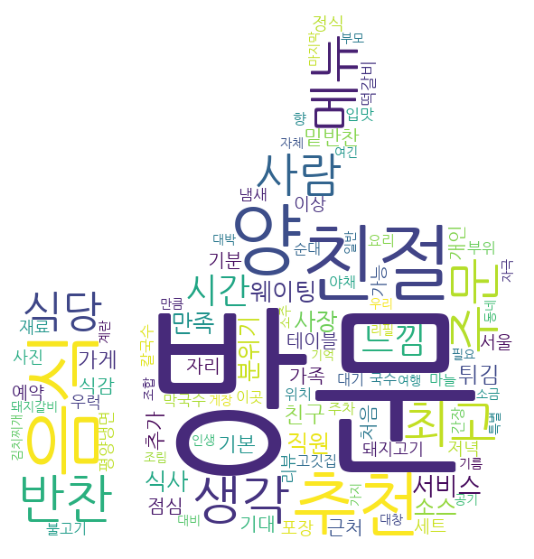

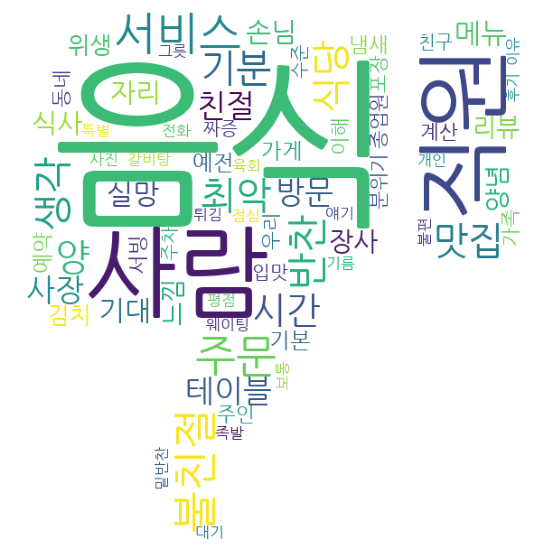

In [ ]:
# 시각화. Wordcloud

good_image = Image.open('good.png') 
bad_image = Image.open('bad.png')

good_mask = np.array(Image.open('good.png'))
bad_mask = np.array(Image.open('bad.png'))

# 한글 폰트 설정하기
font = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# WordClod 객체 만들기
good_wordcloud = WordCloud(font_path=font,
                           width=8000,
                           height=8000,
                           max_font_size=2000,
                           max_words=100,
                           background_color='white',
                           mask=good_mask)

bad_wordcloud = WordCloud(font_path=font,
                          width=8000,
                          height=8000,
                          max_font_size=3000,
                          max_words=70,
                          background_color='white',
                          mask=bad_mask)

# wordcloud 이미지 생성 및 출력
good_wordcloud.generate_from_frequencies(good_counts)

plt.figure(figsize=(7,7))
plt.imshow(good_wordcloud)
plt.axis('off')
plt.show()
print('='*100)



bad_wordcloud.generate_from_frequencies(bad_counts)

plt.figure(figsize=(7,7))
plt.imshow(bad_wordcloud)
plt.axis('off')
plt.show()